In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

df = pd.read_csv('/content/healthcare-dataset-stroke-data.csv')
df.rename(columns={'avg_glucose_level': 'glucose'}, inplace=True)
df.drop(['id'],axis=1,inplace=True)
df['bmi'] = df['bmi'].fillna(df['bmi'].mean())

def cap_upper_outliers(series):
    upper = series.quantile(0.75) + 1.5 * (series.quantile(0.75) - series.quantile(0.25))
    return series.clip(upper=upper)

df['bmi'] = cap_upper_outliers(df['bmi'])
df['glucose'] = np.log(df['glucose'] + 1)

numeric_cols = ["age", "glucose", "bmi"]
scaler = RobustScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
cate_cols = df.columns.difference(numeric_cols)
encoder = LabelEncoder()
for col in cate_cols:
    df[col] = encoder.fit_transform(df[col])

from sklearn.model_selection import train_test_split
X = df.drop(columns=["stroke"])
y = df["stroke"]
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Hàm train

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.model_selection import GridSearchCV

def comp_model(X_train, y_train, X_test, y_test, metrics):

    models = {
        "LR": (LogisticRegression(random_state=42, max_iter=1000), {
            "C": [0.01, 0.1, 1, 10]
        }),
        "DTree": (DecisionTreeClassifier(random_state=42), {
            "max_depth": [3, 5, 10, None]
        }),
        "RForest": (RandomForestClassifier(random_state=42), {
            "n_estimators": [50, 100],
            "max_depth": [5, 10, None],
            "max_features": ["sqrt", "log2"]
        }),

    }

    train_scores = {metric: [] for metric in metrics}
    test_scores = {metric: [] for metric in metrics}

    for name, (model, params) in models.items():
        print(f"Tuning {name}...")
        clf = GridSearchCV(model, params, cv=5, scoring='f1', n_jobs=-1)  # cv=5 ở đây
        clf.fit(X_train, y_train)
        print(f"Best parameters for {name}: {clf.best_params_}")
        best_model = clf.best_estimator_

        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)
        y_train_proba = best_model.predict_proba(X_train)[:, 1] if hasattr(best_model, "predict_proba") else None
        y_test_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None

        train_scores["Accuracy"].append(accuracy_score(y_train, y_train_pred))
        train_scores["F1 Score"].append(f1_score(y_train, y_train_pred))
        train_scores["AUC"].append(roc_auc_score(y_train, y_train_proba) if y_train_proba is not None else 0)
        test_scores["Accuracy"].append(accuracy_score(y_test, y_test_pred))
        test_scores["F1 Score"].append(f1_score(y_test, y_test_pred))
        test_scores["AUC"].append(roc_auc_score(y_test, y_test_proba) if y_test_proba is not None else 0)
        print(f"F1-Score for Train Dataset {name}: {f1_score(y_train, y_train_pred)}")
        print(f"F1-Score for Valid Dataset {name}: {f1_score(y_test, y_test_pred)}")

    # Vẽ biểu đồ như cũ
    plt.figure(figsize=(8, 6))
    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i + 1)
        sns.barplot(x=list(models.keys()), y=train_scores[metric], color="skyblue", label="Train", width=0.5)
        sns.barplot(x=list(models.keys()), y=test_scores[metric], color="salmon", alpha=0.8, label="Test", width=0.5)
        plt.title(metric, fontsize=12)
        plt.xticks(rotation=45, fontsize=9)
        plt.ylabel(metric, fontsize=10)
        plt.legend(fontsize=9)
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()


# Trước khi sử dụng SMOTE

Tuning LR...
Best parameters for LR: {'C': 0.01}
F1-Score for Train Dataset LR: 0.0
F1-Score for Valid Dataset LR: 0.0
Tuning DTree...
Best parameters for DTree: {'max_depth': None}
F1-Score for Train Dataset DTree: 1.0
F1-Score for Valid Dataset DTree: 0.22807017543859648
Tuning RForest...
Best parameters for RForest: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 50}
F1-Score for Train Dataset RForest: 0.9924050632911392
F1-Score for Valid Dataset RForest: 0.037037037037037035


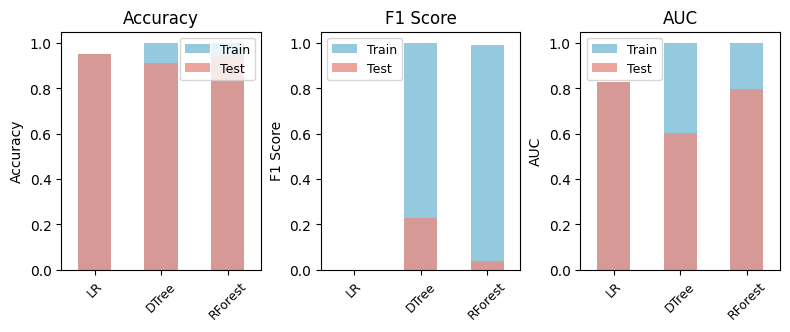

In [17]:
metrics = ["Accuracy", "F1 Score",  "AUC"]
comp_model(X_train, y_train, X_val, y_val, metrics)

# Thêm hai mô hình Elastic Net và XGBoost

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, accuracy_score


def comp_model(X_train, y_train, X_test, y_test):
    from sklearn.linear_model import LogisticRegression
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
    from xgboost import XGBClassifier
    from sklearn.model_selection import GridSearchCV

    models = {
        "LR": (LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000), {}),
        "ElasticNet": (LogisticRegression(
            penalty='elasticnet',
            solver='saga',
            random_state=42,
            max_iter=1000
        ), {
            "C": [0.01, 0.1, 1, 10],
            "l1_ratio": [0.1, 0.5, 0.9]
        }),
        "DTree": (DecisionTreeClassifier(random_state=42), {
            "max_depth": [3, 5, 10, None]
        }),
        "RForest": (RandomForestClassifier(random_state=42), {
            "n_estimators": [50, 100],
            "max_depth": [5, 10, None],
            "max_features": ["sqrt", "log2", None]
        }),
        "XGBoost": (XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), {
            "n_estimators": [50, 100],
            "max_depth": [3, 5],
            "learning_rate": [0.05, 0.1]
        })
    }

    train_f1s = []
    test_f1s = []
    train_accs = []
    test_accs = []
    train_recall = []
    test_recall = []

    for name, (model, params) in models.items():
        print(f"Tuning {name} ...")
        clf = GridSearchCV(model, params, scoring='recall', cv=5, n_jobs=-1)
        clf.fit(X_train, y_train)
        best_model = clf.best_estimator_

        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)

        train_f1s.append(f1_score(y_train, y_train_pred))
        test_f1s.append(f1_score(y_test, y_test_pred))
        train_accs.append(accuracy_score(y_train, y_train_pred))
        test_accs.append(accuracy_score(y_test, y_test_pred))
        train_recall.append(recall_score(y_train, y_train_pred))
        test_recall.append(recall_score(y_test, y_test_pred))

    # Vẽ biểu đồ Recall train vs test
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(models.keys()), y=train_recall, color="skyblue", label="Train Recall")
    sns.barplot(x=list(models.keys()), y=test_recall, color="salmon", alpha=0.7, label="Test Recall")
    plt.title("Recall Scores on Train and Validation Sets")
    plt.ylabel("Recall Score")
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

Tuning LR ...
Tuning ElasticNet ...
Tuning DTree ...
Tuning RForest ...
Tuning XGBoost ...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:26:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


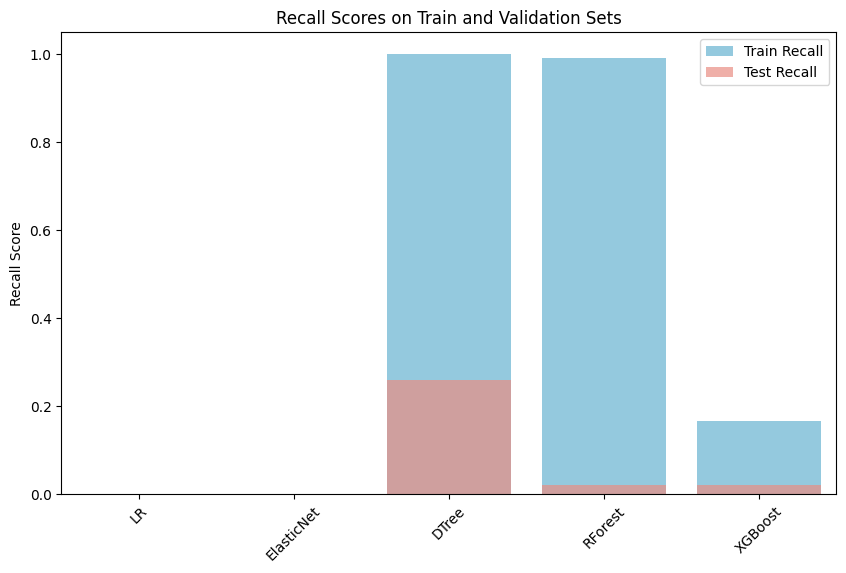

In [19]:
comp_model(X_train, y_train, X_val, y_val)

# Sau khi sử dụng Borderline-SMOTE

Tuning LR ...
Tuning ElasticNet ...
Tuning DTree ...
Tuning RForest ...
Tuning XGBoost ...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:28:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


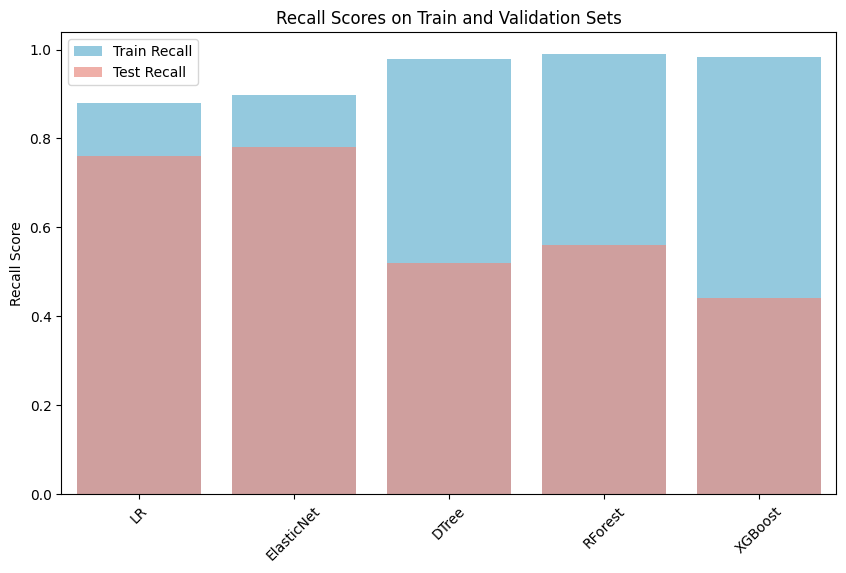

In [20]:
from imblearn.over_sampling import BorderlineSMOTE
borderline_smote = BorderlineSMOTE(random_state=42, kind='borderline-2')
X_train2, y_train2 = borderline_smote.fit_resample(X_train, y_train)
best_thresholds = comp_model(X_train2, y_train2, X_val, y_val)


# Dùng SMOTE

Tuning LR ...
Tuning ElasticNet ...
Tuning DTree ...
Tuning RForest ...
Tuning XGBoost ...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:29:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


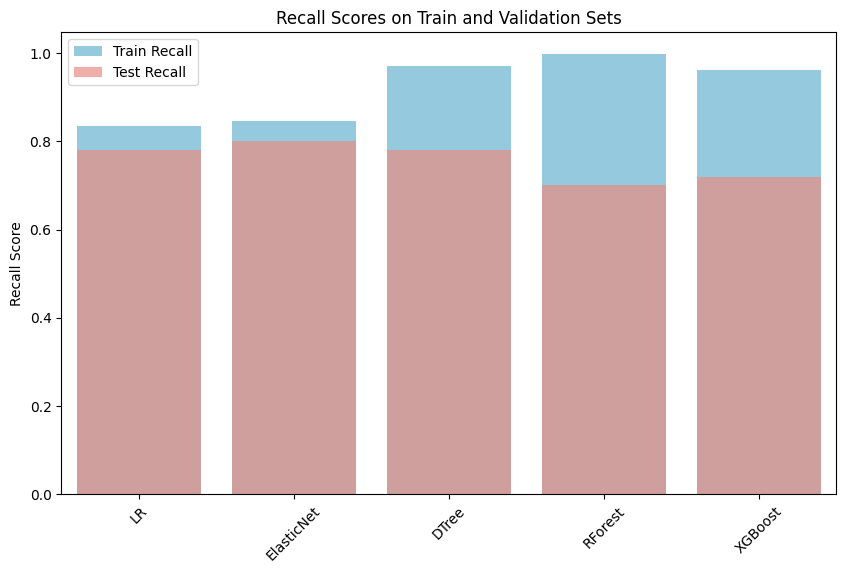

In [21]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train2, y_train2 = smote.fit_resample(X_train, y_train)
comp_model(X_train2, y_train2, X_val, y_val)


# Random Oversampling

Tuning LR ...
Tuning ElasticNet ...
Tuning DTree ...
Tuning RForest ...
Tuning XGBoost ...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:30:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


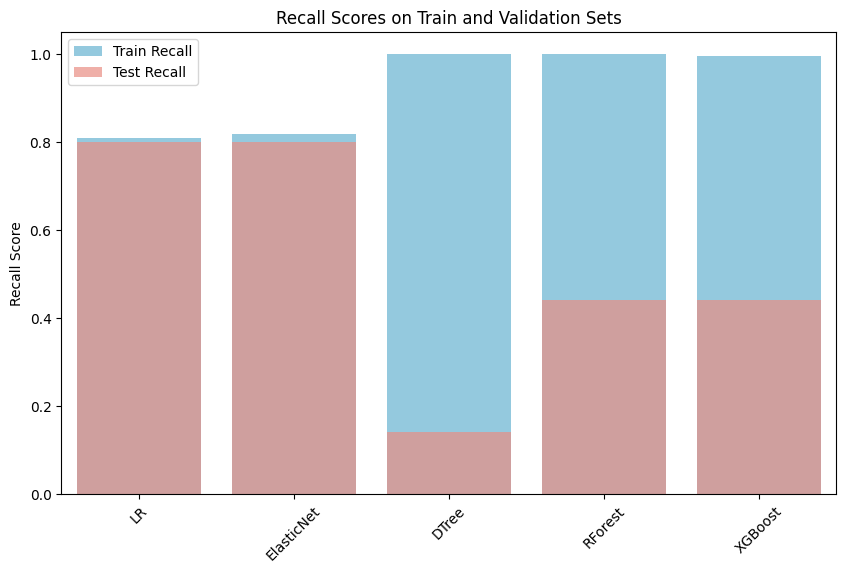

In [22]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train2, y_train2 = ros.fit_resample(X_train, y_train)
best_thresholds = comp_model(X_train2, y_train2, X_val, y_val)

# In ra các tham số tối ưu để code scratch

In [27]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train2, y_train2 = smote.fit_resample(X_train, y_train)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, accuracy_score

def comp_model(X_train, y_train, X_test, y_test):
    from sklearn.linear_model import LogisticRegression
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
    from xgboost import XGBClassifier
    from sklearn.model_selection import GridSearchCV

    models = {
        "LR": (LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000), {}),
        "ElasticNet": (LogisticRegression(
            penalty='elasticnet',
            solver='saga',
            random_state=42,
            max_iter=1000
        ), {
            "C": [0.01, 0.1, 1, 10],
            "l1_ratio": [0.1, 0.5, 0.9]
        }),
        "DTree": (DecisionTreeClassifier(random_state=42), {
            "max_depth": [3, 5, 10]
        }),
        "RForest": (RandomForestClassifier(random_state=42), {
            "n_estimators": [50, 100],
            "max_depth": [5, 10, None],
            "max_features": ["sqrt", "log2", None]
        }),
        "XGBoost": (XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), {
            "n_estimators": [50, 100],
            "max_depth": [3, 5],
            "learning_rate": [0.05, 0.1]
        })
    }

    for name, (model, params) in models.items():
        print(f"Tuning {name} ...")
        clf = GridSearchCV(model, params, scoring='recall', cv=5, n_jobs=-1)
        clf.fit(X_train, y_train)
        print(f"Best parameters for {name}: {clf.best_params_}")

        best_model = clf.best_estimator_

        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)

        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        train_rec = recall_score(y_train, y_train_pred)
        test_rec = recall_score(y_test, y_test_pred)

        print(f"{name} - Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
        print(f"{name} - Train Recall: {train_rec:.4f}, Test Recall: {test_rec:.4f}\n")


comp_model(X_train2, y_train2, X_val, y_val)

Tuning LR ...
Best parameters for LR: {}
LR - Train Accuracy: 0.7915, Test Accuracy: 0.7583
LR - Train Recall: 0.8354, Test Recall: 0.7800

Tuning ElasticNet ...
Best parameters for ElasticNet: {'C': 0.01, 'l1_ratio': 0.5}
ElasticNet - Train Accuracy: 0.7868, Test Accuracy: 0.7427
ElasticNet - Train Recall: 0.8460, Test Recall: 0.8000

Tuning DTree ...
Best parameters for DTree: {'max_depth': 5}
DTree - Train Accuracy: 0.8244, Test Accuracy: 0.6967
DTree - Train Recall: 0.9717, Test Recall: 0.7800

Tuning RForest ...
Best parameters for RForest: {'max_depth': 10, 'max_features': None, 'n_estimators': 50}
RForest - Train Accuracy: 0.9193, Test Accuracy: 0.8219
RForest - Train Recall: 0.9979, Test Recall: 0.7000

Tuning XGBoost ...
Best parameters for XGBoost: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 50}
XGBoost - Train Accuracy: 0.8555, Test Accuracy: 0.7515
XGBoost - Train Recall: 0.9619, Test Recall: 0.7200



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:44:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# So sánh Code thư viện và from scratch

## LR

In [32]:
lr = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000)
lr.fit(X_train2, y_train2)
y_val_pred = lr.predict(X_val)
print(accuracy_score(y_val, y_val_pred), recall_score(y_val, y_val_pred), f1_score(y_val, y_val_pred))

0.7583170254403131 0.78 0.24


In [53]:
import joblib
joblib.dump(lr, 'lr_model.joblib')

['lr_model.joblib']

In [37]:
import numpy as np

def sigmoid(z):
  return 1/(1+np.exp(-z))

def loss_ce(y_p,y):
  epsilon = 1e-15
  y_p = np.clip(y_p, epsilon, 1-epsilon)
  return np.mean(-y*np.log(y_p) - (1-y)*np.log(1-y_p))

def lr_gradient(X, y_p, y):
  m = X.shape[0]
  error = y_p - y
  grad_w = (1/m) * np.dot(X.T, error)
  grad_b = (1/m) * np.sum(error)
  return grad_w, grad_b


def train_lr(X, y, lr=0.1, epochs=1000):
    m, n = X.shape
    w = np.zeros(n)
    b = 0
    for epoch in range(epochs):
        z = np.dot(X, w) + b
        y_p = sigmoid(z)
        loss = loss_ce(y_p, y)
        grad_w, grad_b = lr_gradient(X, y_p, y)
        w -= lr * grad_w
        b -= lr * grad_b

    return w, b

def predict(X, w, b, threshold=0.5):
    z = np.dot(X, w) + b
    y_p = sigmoid(z)
    return (y_p >= threshold).astype(int)

w, b = train_lr(X_train2.values, y_train2.values, lr=0.01, epochs=1000)
y_val_pred = predict(X_val.values, w, b)
print(accuracy_score(y_val, y_val_pred), recall_score(y_val, y_val_pred), f1_score(y_val, y_val_pred))

0.7093933463796478 0.82 0.21635883905013192


In [52]:
import joblib
model_params = {'w': w, 'b': b}
joblib.dump(model_params, 'lr_scratch.joblib')

['lr_scratch.joblib']

## Decision Tree

In [38]:
dtree = DecisionTreeClassifier(max_depth=5, random_state=42)
dtree.fit(X_train2, y_train2)
y_val_pred = dtree.predict(X_val)
print(accuracy_score(y_val, y_val_pred), recall_score(y_val, y_val_pred), f1_score(y_val, y_val_pred))

0.6966731898238747 0.78 0.20103092783505155


In [54]:
import joblib
joblib.dump(dtree, 'dtree_lib.joblib')

['dtree_lib.joblib']

In [39]:
import numpy as np
from collections import Counter

def entropy(y):
    counts = np.bincount(y)
    probabilities = counts / len(y)
    return -np.sum([p * np.log2(p) for p in probabilities if p > 0])

def split(X_column, threshold):
    left_indices = np.where(X_column <= threshold)[0]
    right_indices = np.where(X_column > threshold)[0]
    return left_indices, right_indices

def information_gain(y, left_indices, right_indices):
    parent_entropy = entropy(y)
    n = len(y)
    n_left, n_right = len(left_indices), len(right_indices)

    if n_left == 0 or n_right == 0:
        return 0

    left_entropy = entropy(y[left_indices])
    right_entropy = entropy(y[right_indices])
    child_entropy = (n_left/n) * left_entropy + (n_right/n) * right_entropy

    return parent_entropy - child_entropy
def best_split(X, y):
    best_gain = -1
    split_idx, split_thresh = None, None
    n_samples, n_features = X.shape

    for feature_index in range(n_features):
        thresholds = np.unique(X[:, feature_index])
        for threshold in thresholds:
            left_indices, right_indices = split(X[:, feature_index], threshold)
            gain = information_gain(y, left_indices, right_indices)

            if gain > best_gain:
                best_gain = gain
                split_idx = feature_index
                split_thresh = threshold

    return split_idx, split_thresh

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value  # dùng cho leaf node

    def is_leaf_node(self):
        return self.value is not None

def build_tree(X, y, depth=0, max_depth=3):
    num_samples_per_class = Counter(y)
    most_common = num_samples_per_class.most_common(1)[0][0]

    # Stopping conditions
    if depth >= max_depth or len(np.unique(y)) == 1:
        return Node(value=most_common)

    feature_idx, threshold = best_split(X, y)
    if feature_idx is None:
        return Node(value=most_common)

    left_indices, right_indices = split(X[:, feature_idx], threshold)
    left = build_tree(X[left_indices, :], y[left_indices], depth + 1, max_depth)
    right = build_tree(X[right_indices, :], y[right_indices], depth + 1, max_depth)
    return Node(feature=feature_idx, threshold=threshold, left=left, right=right)

def predict_one(x, node):
    while not node.is_leaf_node():
        if x[node.feature] <= node.threshold:
            node = node.left
        else:
            node = node.right
    return node.value

def predict(X, tree):
    return np.array([predict_one(x, tree) for x in X])

# Giả sử bạn đã có X_train, y_train, X_test
tree = build_tree(X_train2.values, y_train2.values, max_depth=5)
y_val_pred = predict(X_val.values, tree)
print(accuracy_score(y_val, y_val_pred), recall_score(y_val, y_val_pred), f1_score(y_val, y_val_pred))

0.6741682974559687 0.78 0.1897810218978102


## Random Forest

In [40]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train2, y_train2)
y_val_pred = rf.predict(X_val)
print(accuracy_score(y_val, y_val_pred), recall_score(y_val, y_val_pred), f1_score(y_val, y_val_pred))

0.6927592954990215 0.84 0.21105527638190955


In [42]:
import numpy as np
from collections import Counter
from typing import List, Tuple, Any

class DecisionNode:
    def __init__(self, feature_idx: int = None, threshold: float = None,
                 left = None, right = None, value: Any = None):
        self.feature_idx = feature_idx  # Index of feature to split on
        self.threshold = threshold      # Threshold value for split
        self.left = left               # Left child node
        self.right = right             # Right child node
        self.value = value             # Predicted value for leaf node

class DecisionTree:
    def __init__(self, max_depth: int = None, min_samples_split: int = 2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self.root = self._grow_tree(X, y, depth=0)

    def _grow_tree(self, X: np.ndarray, y: np.ndarray, depth: int) -> DecisionNode:
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))

        # Stopping criteria
        if (self.max_depth is not None and depth >= self.max_depth) or \
           n_samples < self.min_samples_split or \
           n_classes == 1:
            return DecisionNode(value=self._most_common_label(y))

        # Find best split
        best_gain = -1
        best_split = None
        # Randomly select features to consider
        feature_indices = np.random.choice(n_features, int(np.sqrt(n_features)), replace=False)

        for feature_idx in feature_indices:
          values = np.sort(np.unique(X[:, feature_idx]))
          thresholds = (values[:-1] + values[1:]) / 2  # Midpoints
          for threshold in thresholds:
              left_indices = X[:, feature_idx] <= threshold
              right_indices = X[:, feature_idx] > threshold

              if sum(left_indices) == 0 or sum(right_indices) == 0:
                  continue

              gain = self._information_gain(y, left_indices, right_indices)
              if gain > best_gain:
                  best_gain = gain
                  best_split = (feature_idx, threshold)

        if best_gain == -1:
                return DecisionNode(value=self._most_common_label(y))

        # Create child splits
        feature_idx, threshold = best_split
        left_indices = X[:, feature_idx] <= threshold
        right_indices = X[:, feature_idx] > threshold

        left = self._grow_tree(X[left_indices], y[left_indices], depth + 1)
        right = self._grow_tree(X[right_indices], y[right_indices], depth + 1)
        return DecisionNode(feature_idx, threshold, left, right)

    def _information_gain(self, y: np.ndarray, left_indices: np.ndarray,
                         right_indices: np.ndarray) -> float:
        parent_entropy = self._entropy(y)

        n = len(y)
        n_left, n_right = sum(left_indices), sum(right_indices)
        if n_left == 0 or n_right == 0:
            return 0

        child_entropy = (n_left / n) * self._entropy(y[left_indices]) + \
                       (n_right / n) * self._entropy(y[right_indices])
        return parent_entropy - child_entropy

    def _entropy(self, y: np.ndarray) -> float:
        proportions = np.bincount(y) / len(y)
        return -np.sum([p * np.log2(p) for p in proportions if p > 0])

    def _most_common_label(self, y: np.ndarray) -> Any:
        return Counter(y).most_common(1)[0][0]

    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x: np.ndarray, node: DecisionNode) -> Any:
        if node.value is not None:
            return node.value
        if x[node.feature_idx] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

class RandomForest:
    def __init__(self, n_estimators: int = 100, max_depth: int = None,
                 min_samples_split: int = 2, bootstrap: bool = True):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.bootstrap = bootstrap
        self.trees = []

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self.trees = []
        n_samples = X.shape[0]

        for _ in range(self.n_estimators):
            # Create bootstrap sample
            if self.bootstrap:
                indices = np.random.choice(n_samples, n_samples, replace=True)
                X_sample = X[indices]
                y_sample = y[indices]
            else:
                X_sample, y_sample = X, y

            # Train decision tree
            tree = DecisionTree(max_depth=self.max_depth,
                              min_samples_split=self.min_samples_split)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        # Get predictions from all trees
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        # Majority vote
        return np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=tree_preds)

# Example usage:
if __name__ == "__main__":
    rf = RandomForest(n_estimators=50, max_depth=10, min_samples_split=2)
    rf.fit(X_train2.values, y_train2.values)


TypeError: predict() takes 2 positional arguments but 3 were given

In [43]:
y_val_pred = rf.predict(X_val.values)
print(accuracy_score(y_val, y_val_pred), recall_score(y_val, y_val_pred), f1_score(y_val, y_val_pred))

0.7749510763209393 0.66 0.22297297297297297


## Elastic Net

In [44]:
elastic_net_model = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    C=0.01,
    l1_ratio=0.5,
    max_iter=1000,
    random_state=42
)

elastic_net_model.fit(X_train2, y_train2)
y_val_pred = elastic_net_model.predict(X_val)
print(accuracy_score(y_val, y_val_pred), recall_score(y_val, y_val_pred), f1_score(y_val, y_val_pred))

0.7426614481409002 0.8 0.23323615160349853


In [45]:
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, f1_score

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def loss_elastic_net(y_p, y, w, alpha=0.01, l1_ratio=0.5):
    """
    alpha: tổng hệ số regularization
    l1_ratio: tỉ lệ L1 trong tổng regularization (0 = Ridge, 1 = Lasso)
    """
    epsilon = 1e-15
    y_p = np.clip(y_p, epsilon, 1 - epsilon)
    loss_ce = -np.mean(y * np.log(y_p) + (1 - y) * np.log(1 - y_p))
    l1 = l1_ratio * np.sum(np.abs(w))
    l2 = (1 - l1_ratio) * 0.5 * np.sum(w**2)
    return loss_ce + alpha * (l1 + l2)

def lr_gradient_elastic(X, y_p, y, w, alpha=0.01, l1_ratio=0.5):
    m = X.shape[0]
    error = y_p - y
    grad_w = (1/m) * np.dot(X.T, error)
    grad_b = (1/m) * np.sum(error)

    # Elastic Net Regularization Gradient
    grad_w += alpha * (l1_ratio * np.sign(w) + (1 - l1_ratio) * w)
    return grad_w, grad_b

def train_elastic_lr(X, y, lr=0.01, epochs=1000, alpha=0.01, l1_ratio=0.5):
    m, n = X.shape
    w = np.zeros(n)
    b = 0

    for epoch in range(epochs):
        z = np.dot(X, w) + b
        y_p = sigmoid(z)
        loss = loss_elastic_net(y_p, y, w, alpha, l1_ratio)
        grad_w, grad_b = lr_gradient_elastic(X, y_p, y, w, alpha, l1_ratio)
        w -= lr * grad_w
        b -= lr * grad_b

    return w, b

def predict(X, w, b, threshold=0.5):
    z = np.dot(X, w) + b
    y_p = sigmoid(z)
    return (y_p >= threshold).astype(int)

w, b = train_elastic_lr(
    X_train2.values, y_train2.values,
    lr=0.01,
    epochs=1000,
    alpha=0.01,
    l1_ratio=0.5
)

y_val_pred = predict(X_val.values, w, b)
print(accuracy_score(y_val, y_val_pred), recall_score(y_val, y_val_pred), f1_score(y_val, y_val_pred))

0.7074363992172211 0.82 0.2152230971128609


## XGBoost

In [48]:
xgb_model = XGBClassifier(
    learning_rate=0.05,
    max_depth=5,
    n_estimators=50,
    eval_metric='logloss',     # metric phổ biến cho classification
    random_state=42
)

xgb_model.fit(X_train2, y_train2)
y_val_pred = xgb_model.predict(X_val)
print(accuracy_score(y_val, y_val_pred), recall_score(y_val, y_val_pred), f1_score(y_val, y_val_pred))

0.7514677103718199 0.72 0.22085889570552147


In [ ]:
import numpy as np
import pandas as pd

class Node:
    '''
    Node của cây quyết định cho XGBoost regression tree.
    '''

    def __init__(self, x, gradient, hessian, idxs,
                 subsample_cols=0.8, min_leaf=5, min_child_weight=1,
                 depth=10, lambda_=1, gamma=1, eps=0.1):
        self.x = x
        self.gradient = gradient
        self.hessian = hessian
        self.idxs = idxs
        self.depth = depth
        self.min_leaf = min_leaf
        self.lambda_ = lambda_
        self.gamma = gamma
        self.min_child_weight = min_child_weight
        self.row_count = len(idxs)
        self.col_count = x.shape[1]
        self.subsample_cols = subsample_cols
        self.eps = eps

        # Random chọn cột để phân chia
        self.column_subsample = np.random.permutation(self.col_count)[:round(self.subsample_cols * self.col_count)]

        # Giá trị lá (leaf value)
        self.val = self.compute_gamma(self.gradient[self.idxs], self.hessian[self.idxs])

        # Điểm score tốt nhất tìm được
        self.score = float('-inf')
        self.var_idx = None
        self.split = None
        self.lhs = None
        self.rhs = None

        self.find_varsplit()

    def compute_gamma(self, gradient, hessian):
        '''Tính giá trị leaf (equation (5) trong XGBoost paper)'''
        return -np.sum(gradient) / (np.sum(hessian) + self.lambda_)

    def find_varsplit(self):
        '''Tìm biến và điểm split tốt nhất'''
        for c in self.column_subsample:
            self.find_greedy_split(c)
        if self.is_leaf:
            return
        x_col = self.split_col
        lhs = np.nonzero(x_col <= self.split)[0]
        rhs = np.nonzero(x_col > self.split)[0]
        self.lhs = Node(self.x, self.gradient, self.hessian, self.idxs[lhs],
                        self.subsample_cols, self.min_leaf, self.min_child_weight,
                        self.depth - 1, self.lambda_, self.gamma, self.eps)
        self.rhs = Node(self.x, self.gradient, self.hessian, self.idxs[rhs],
                        self.subsample_cols, self.min_leaf, self.min_child_weight,
                        self.depth - 1, self.lambda_, self.gamma, self.eps)

    def find_greedy_split(self, var_idx):
        '''Tìm điểm split greedy tốt nhất trên cột var_idx'''
        x = self.x[self.idxs, var_idx]
        for r in range(self.row_count):
            lhs = x <= x[r]
            rhs = x > x[r]

            lhs_indices = np.nonzero(lhs)[0]
            rhs_indices = np.nonzero(rhs)[0]

            if (rhs.sum() < self.min_leaf or lhs.sum() < self.min_leaf or
                self.hessian[self.idxs[lhs_indices]].sum() < self.min_child_weight or
                self.hessian[self.idxs[rhs_indices]].sum() < self.min_child_weight):
                continue

            curr_score = self.gain(lhs, rhs)
            if curr_score > self.score:
                self.var_idx = var_idx
                self.score = curr_score
                self.split = x[r]

    def gain(self, lhs, rhs):
        '''Tính gain (equation (7) trong XGBoost paper)'''
        gradient = self.gradient[self.idxs]
        hessian = self.hessian[self.idxs]

        lhs_gradient = gradient[lhs].sum()
        lhs_hessian = hessian[lhs].sum()
        rhs_gradient = gradient[rhs].sum()
        rhs_hessian = hessian[rhs].sum()

        gain = 0.5 * (
            (lhs_gradient ** 2) / (lhs_hessian + self.lambda_) +
            (rhs_gradient ** 2) / (rhs_hessian + self.lambda_) -
            ((lhs_gradient + rhs_gradient) ** 2) / (lhs_hessian + rhs_hessian + self.lambda_)
        ) - self.gamma

        return gain

    @property
    def split_col(self):
        return self.x[self.idxs, self.var_idx]

    @property
    def is_leaf(self):
        return self.score == float('-inf') or self.depth <= 0

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf:
            return self.val
        node = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return node.predict_row(xi)


class XGBoostTree:
    '''
    Wrapper cây đơn (regression tree) trong XGBoost
    '''
    def fit(self, x, gradient, hessian, subsample_cols=0.8,
            min_leaf=5, min_child_weight=1, depth=10, lambda_=1, gamma=1, eps=0.1):
        self.dtree = Node(x, gradient, hessian, np.arange(len(x)),
                          subsample_cols, min_leaf, min_child_weight,
                          depth, lambda_, gamma, eps)
        return self

    def predict(self, X):
        return self.dtree.predict(X)


class XGBoostClassifier:
    '''
    XGBoost cho bài toán phân loại nhị phân (binary classification)
    '''
    def __init__(self):
        self.estimators = []

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    def grad(self, preds, labels):
        preds = self.sigmoid(preds)
        return preds - labels

    def hess(self, preds, labels):
        preds = self.sigmoid(preds)
        return preds * (1 - preds)

    def fit(self, X, y, subsample_cols=0.8, min_child_weight=1, depth=5, min_leaf=5,
            learning_rate=0.4, boosting_rounds=5, lambda_=1.5, gamma=1, eps=0.1):
        self.X = X.values if isinstance(X, pd.DataFrame) else X
        self.y = y.values if isinstance(y, pd.Series) else y
        self.depth = depth
        self.subsample_cols = subsample_cols
        self.eps = eps
        self.min_child_weight = min_child_weight
        self.min_leaf = min_leaf
        self.learning_rate = learning_rate
        self.boosting_rounds = boosting_rounds
        self.lambda_ = lambda_
        self.gamma = gamma

        # Khởi tạo dự đoán ban đầu (log odds của tỉ lệ dương)
        p = np.mean(self.y)
        self.base_pred = np.full(self.X.shape[0], np.log(p / (1 - p)))

        for _ in range(self.boosting_rounds):
            Grad = self.grad(self.base_pred, self.y)
            Hess = self.hess(self.base_pred, self.y)
            tree = XGBoostTree().fit(self.X, Grad, Hess,
                                     subsample_cols=self.subsample_cols,
                                     min_leaf=self.min_leaf,
                                     min_child_weight=self.min_child_weight,
                                     depth=self.depth,
                                     lambda_=self.lambda_,
                                     gamma=self.gamma,
                                     eps=self.eps)
            update = tree.predict(self.X)
            self.base_pred += self.learning_rate * update
            self.estimators.append(tree)

        return self

    def predict_proba(self, X):
        X = X.values if isinstance(X, pd.DataFrame) else X
        pred = np.full(X.shape[0], self.base_pred[0])
        for tree in self.estimators:
            pred += self.learning_rate * tree.predict(X)
        proba = self.sigmoid(pred)
        return np.vstack((1 - proba, proba)).T

    def predict(self, X):
        proba = self.predict_proba(X)[:, 1]
        return (proba >= 0.5).astype(int)

model = XGBoostClassifier()
model.fit(X_train2.values, y_train2.values)
y_val_pred = model.predict(X_val.values)
print(accuracy_score(y_val, y_val_pred), recall_score(y_val, y_val_pred), f1_score(y_val, y_val_pred))
